<a href="https://colab.research.google.com/github/alhussad/flash/blob/master/Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# Import the necessary libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np 
import pandas as pd 
import matplotlib
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score 

In [4]:
# Load and read the dataset
dataset_path = '/content/gdrive/My Drive/Dissertation/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'
df = pd.read_csv(dataset_path, encoding = "ISO-8859-1", engine='python')

In [5]:
# Display the first five rows of the dataframe
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,33898.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113095465.0,48.0,24.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,BENIGN
1,192.168.10.3-192.168.10.50-389-33904-6,192.168.10.50,33904.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113473706.0,68.0,40.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,BENIGN
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 8:59,119945515.0,150.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,BENIGN
3,192.168.10.14-65.55.44.109-59135-443-6,192.168.10.14,59135.0,65.55.44.109,443.0,6.0,6/7/2017 8:59,60261928.0,9.0,7.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.14-53-59555-17,192.168.10.14,59555.0,192.168.10.3,53.0,17.0,6/7/2017 8:59,269.0,2.0,2.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN


In [6]:
# Print information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458968 entries, 0 to 458967
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       170366 non-null  object 
 1    Source IP                    170366 non-null  object 
 2    Source Port                  170366 non-null  float64
 3    Destination IP               170366 non-null  object 
 4    Destination Port             170366 non-null  float64
 5    Protocol                     170366 non-null  float64
 6    Timestamp                    170366 non-null  object 
 7    Flow Duration                170366 non-null  float64
 8    Total Fwd Packets            170366 non-null  float64
 9    Total Backward Packets       170366 non-null  float64
 10  Total Length of Fwd Packets   170366 non-null  float64
 11   Total Length of Bwd Packets  170366 non-null  float64
 12   Fwd Packet Length Max        170366 non-nul

In [7]:
# Remove the space characters in column names
df.columns = df.columns.str.strip()

In [8]:
# The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.
df = df.drop(columns=['Fwd Header Length.1'])

In [9]:
print(f'Dimensions of the Data set : Rows={df.shape[0]}, Columns={df.shape[1]}')

Dimensions of the Data set : Rows=458968, Columns=84


In [10]:
# Checking for missing value
df.isna().sum()

Flow ID             288602
Source IP           288602
Source Port         288602
Destination IP      288602
Destination Port    288602
                     ...  
Idle Mean           288602
Idle Std            288602
Idle Max            288602
Idle Min            288602
Label               288602
Length: 84, dtype: int64

In [11]:
# Remove any rows with missing datapoints
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

BENIGN                        168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64

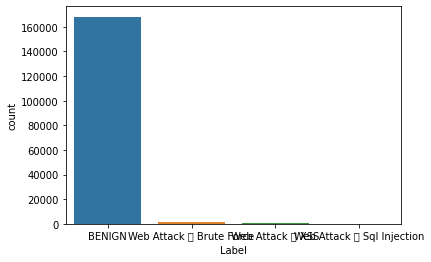

In [12]:
# Check the distribution of target variable
df.Label.value_counts()
sns.countplot(x=df.Label)

In [13]:
# The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.
for i in df.columns:
    df = df[df[i] != "Infinity"]
    df = df[df[i] != np.nan]
    df = df[df[i] != ",,"]

In [14]:
df[['Flow Bytes/s', 'Flow Packets/s']] = df[['Flow Bytes/s', 'Flow Packets/s']].apply(pd.to_numeric)

In [15]:
# Replace any infinity or nan values in the dataset
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [16]:
# Identify the string features
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [17]:
# LabelEncoder
le = LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

In [18]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

0    168186
1      2180
Name: Label, dtype: int64

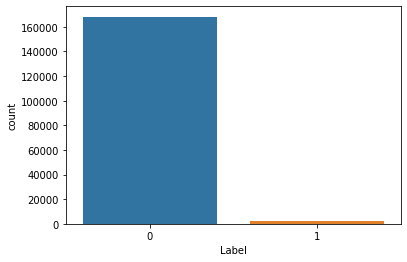

In [19]:
df.Label.value_counts()
sns.countplot(x=df.Label)

In [20]:
# Description of the data in the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Flow ID,170366.0,3.748940e+04,2.722681e+04,0.0,14467.0,29530.0,60933.75,89865.0
Source IP,170366.0,1.355975e+03,5.257467e+02,0.0,1258.0,1262.0,1265.00,4202.0
Source Port,170366.0,4.016057e+04,2.384447e+04,0.0,15765.0,50930.0,59967.00,65534.0
Destination IP,170366.0,1.890148e+03,9.894188e+02,0.0,1590.0,1599.0,1601.00,5213.0
Destination Port,170366.0,7.897091e+03,1.823549e+04,0.0,53.0,80.0,443.00,65529.0
...,...,...,...,...,...,...,...,...
Idle Mean,170366.0,3.690478e+06,1.298830e+07,0.0,0.0,0.0,0.00,120000000.0
Idle Std,170366.0,1.310724e+05,1.733767e+06,0.0,0.0,0.0,0.00,72600000.0
Idle Max,170366.0,3.784764e+06,1.325135e+07,0.0,0.0,0.0,0.00,120000000.0
Idle Min,170366.0,3.543232e+06,1.284183e+07,0.0,0.0,0.0,0.00,120000000.0


In [21]:
# Remove any constant features in the dataset that do not add any value to modelling
df.describe().T[df.describe().T['std']==0]

,count,mean,std,min,25%,50%,75%,max
Bwd PSH Flags,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fwd URG Flags,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bwd URG Flags,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CWE Flag Count,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fwd Avg Bytes/Bulk,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fwd Avg Packets/Bulk,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fwd Avg Bulk Rate,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bwd Avg Bytes/Bulk,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bwd Avg Packets/Bulk,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bwd Avg Bulk Rate,170366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df.shape
print(df['Bwd PSH Flags'].value_counts())
print(df['Bwd URG Flags'].value_counts())
print(df['Fwd Avg Bytes/Bulk'].value_counts())
print(df['Fwd Avg Packets/Bulk'].value_counts())
print(df['Fwd Avg Bulk Rate'].value_counts())
print(df['Bwd Avg Bytes/Bulk'].value_counts())
print(df['Bwd Avg Packets/Bulk'].value_counts())
print(df['Bwd Avg Bulk Rate'].value_counts())

(170366, 84)

0.0    170366
Name: Bwd PSH Flags, dtype: int64
0.0    170366
Name: Bwd URG Flags, dtype: int64
0.0    170366
Name: Fwd Avg Bytes/Bulk, dtype: int64
0.0    170366
Name: Fwd Avg Packets/Bulk, dtype: int64
0.0    170366
Name: Fwd Avg Bulk Rate, dtype: int64
0.0    170366
Name: Bwd Avg Bytes/Bulk, dtype: int64
0.0    170366
Name: Bwd Avg Packets/Bulk, dtype: int64
0.0    170366
Name: Bwd Avg Bulk Rate, dtype: int64


In [23]:
to_be_removed = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 
                 'Init_Win_bytes_backward', 
                 'Init_Win_bytes_forward',
                 'Bwd PSH Flags',
                 'Bwd URG Flags',
                 'Fwd Avg Bytes/Bulk',
                 'Fwd Avg Packets/Bulk',
                 'Fwd Avg Bulk Rate',
                 'Bwd Avg Bytes/Bulk',
                 'Bwd Avg Packets/Bulk',
                 'Bwd Avg Bulk Rate',
                 'Fwd URG Flags',
                 'CWE Flag Count']
df = df.drop(columns=to_be_removed, errors='ignore')

In [24]:
df.shape
df.Label.value_counts()

(170366, 65)

0    168186
1      2180
Name: Label, dtype: int64

In [25]:
y = df['Label'].copy()
X = df.drop(['Label'],axis=1)

In [26]:
# balance the data set
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter
print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler('majority')

X_res, y_res = rus.fit_resample(X, y)
print('Undersampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 168186, 1: 2180})
Undersampled dataset shape Counter({0: 2180, 1: 2180})


In [27]:
dff = X_res
dff['Label'] = y_res

In [28]:
dff = X_res
dff['Label'] = y_res

In [29]:
# Split data into training sets and test sets
train, test = train_test_split(dff,test_size=0.2, random_state=0)

In [30]:
train, val = train_test_split(train,test_size=0.2, random_state=0)

In [31]:
y_train = train['Label']
X_train = train.drop(['Label'],axis=1)

y_val = val['Label']
X_val = val.drop(['Label'],axis=1)

y_test = test['Label']
X_test = test.drop(['Label'],axis=1)

In [32]:
# Scaling numerical attributes
scaler = StandardScaler()

cols = X_train.select_dtypes(include=['float64','int64']).columns

sc_train = scaler.fit_transform(X_train.select_dtypes(include=['float64','int64']))
sc_val = scaler.transform(X_val.select_dtypes(include=['float64','int64']))
sc_test = scaler.transform(X_test.select_dtypes(include=['float64','int64']))

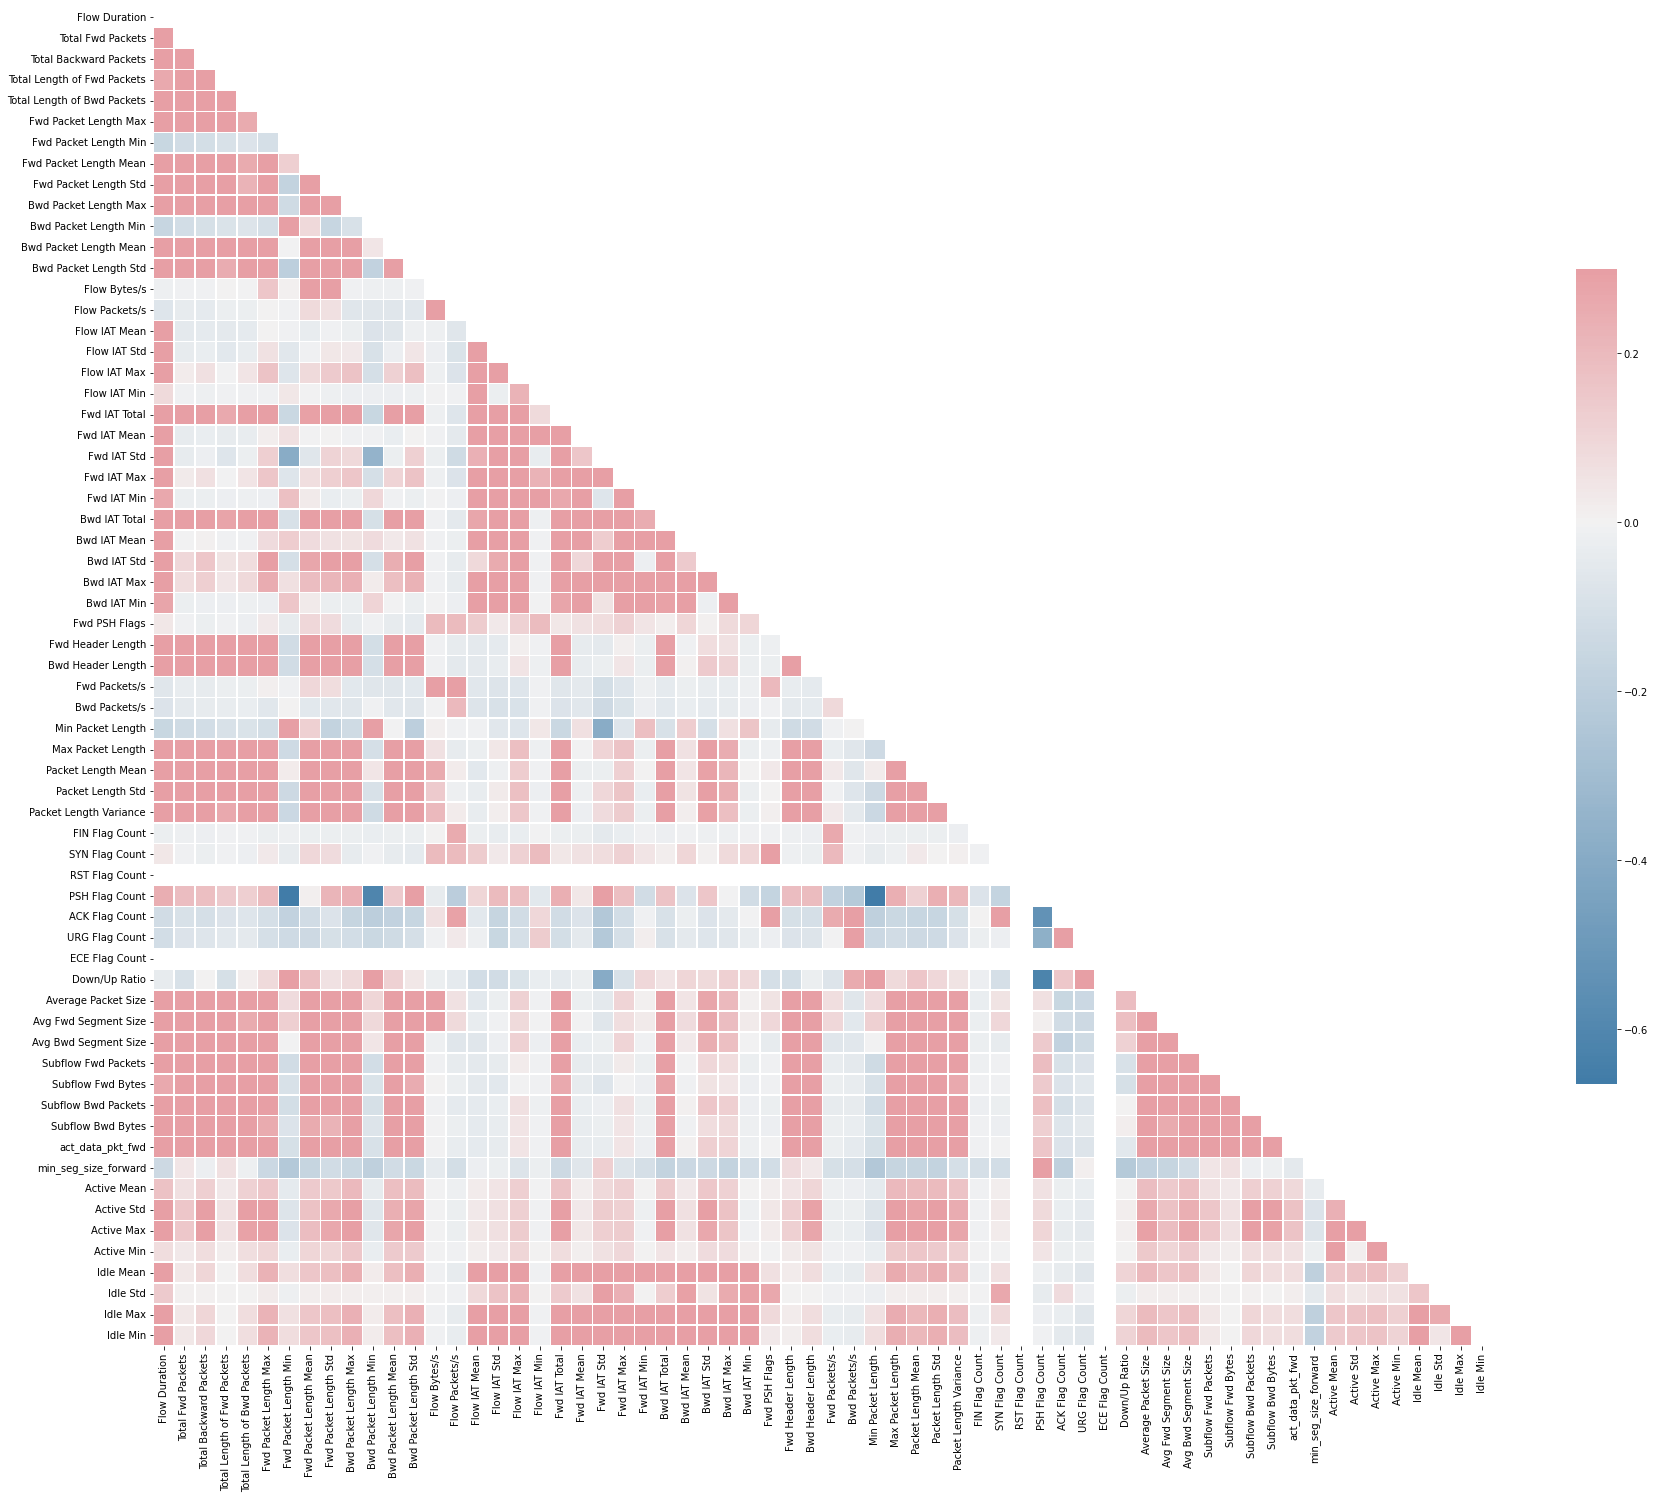

In [33]:
# Compute the correlation matrix
sc_traindf = pd.DataFrame(sc_train, columns = cols)

corr = sc_traindf.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [34]:
# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(sc_train, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [35]:
# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(sc_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [36]:
# Train Decision Tree Model
DTC_Classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(sc_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [37]:
models = []
models.append(('LogisticRegression', LGR_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))

In [38]:
from sklearn import metrics
for i, v in models:
    scores = cross_val_score(v, sc_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_val, v.predict(sc_val))
    confusion_matrix = metrics.confusion_matrix(y_val, v.predict(sc_val))
    classification = metrics.classification_report(y_val, v.predict(sc_val))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== LogisticRegression Model Evaluation ==============================

Cross Validation Mean Score:
 0.96415770609319

Model Accuracy:
 0.9627507163323782

Confusion matrix:
 [[325  18]
 [  8 347]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       343
           1       0.95      0.98      0.96       355

    accuracy                           0.96       698
   macro avg       0.96      0.96      0.96       698
weighted avg       0.96      0.96      0.96       698



============================== KNeighborsClassifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9756272401433691

Model Accuracy:
 0.9727793696275072

Confusion matrix:
 [[334   9]
 [ 10 345]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       343
           1       0.97      0.97      0.97       355

